In [8]:
import random
import math
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn import preprocessing
from math import log

# OTHER SETUP

In [17]:
def curve_plot(rows, cols, X, y, prefix=""):
  axs = (plt.figure(constrained_layout=True)
      .subplots(rows, cols, sharex=True, sharey=True))
  
  if rows > 1:
    for i in range(rows):
      if cols > 1:
        for j in range(cols):
          axs[i][j].set(title = f"{prefix}Input {j}, output {i}")
          axs[i][j].plot(X[:, :, j].tolist()[0], label=f"input {j}")
          axs[i][j].plot(y[:, :, i].tolist()[0], label=f"output {i}")
      else:
        axs[i].set(title = f"{prefix}Input, output {i}")
        axs[i].plot(X[:, :, 0].tolist()[0], label=f"input")
        axs[i].plot(y[:, :, i].tolist()[0], label=f"output {i}")

  else:
    if cols > 1:
      for j in range(cols):
          axs[j].set(title = f"{prefix}Input {j}, output")
          axs[j].plot(X[:, :, j].tolist()[0], label=f"input {j}")
          axs[j].plot(y[:, :, 0].tolist()[0], label=f"output")
    else:
      axs.set(title = f"{prefix}Input, output")
      axs.plot(X.tolist()[0], label=f"input")
      axs.plot(y.tolist()[0], label=f"output")

  print("Blue inputs, orange outputs")
  plt.show()

In [72]:
def filter(arr, kernel_size=4):
  kernel = np.ones(kernel_size)
  kernel = kernel / np.sum(kernel)
  return np.convolve(arr, kernel, mode='full')[:len(arr)]


In [70]:
np.convolve(np.ones(4), np.array([1, 1, 1, 1]))

array([1., 2., 3., 4., 3., 2., 1.])

In [76]:
filter(np.array([1, 1, 1, 1]), 4)

array([0.25, 0.5 , 0.75, 1.  ])

# Artificial Data

In [20]:
def random_sine(samples=50, max_amp=1, min_amp=0, max_freq=5, min_freq=0.2, freq_chaos=0.3, amp_chaos=0.1):
  phase = random.uniform(0, math.pi * 2)
  amp = random.uniform(min_amp, max_amp)
  offset = random.uniform(1-amp, amp-1)
  freq = random.uniform(min_freq, max_freq)
  phase_incr = 2 * freq * math.pi / samples
  output = []

  for _ in range(samples):
    phase += phase_incr
    output.append(math.sin(phase) * amp + offset)
    if random.random() < amp_chaos:
      amp = random.uniform(min_amp, max_amp)
      offset = random.uniform(1-amp, amp-1)
    if random.random() < freq_chaos:
      freq = random.uniform(min_freq, max_freq)
      phase_incr = 2 * freq * math.pi / samples

  return output

In [21]:
def random_nums(samples=50):
  return [random.random() for _ in range(samples)]

In [22]:
def permute_signal(signal, size_reduction = 3, max_pad = 5):
  # remove some points
  new_signal = list(signal)

  for i in range(size_reduction):
    point = random.randint(0, len(new_signal) - 1)
    del new_signal[point]

  # add interpolations
  for i in range(size_reduction):
    point = random.randint(1, len(new_signal) - 1)
    interp = (new_signal[point - 1] + new_signal[point]) / 2
    new_signal.insert(point, interp)

  # add noise
  for i in range(len(new_signal)):
    new_signal[i] += random.uniform(-0.05, 0.05)

  # add some zero padding in the beginning
  pad_num = random.randint(0, max_pad)
  padding = [0 for _ in range(pad_num)]
  new_signal = padding + new_signal[:len(new_signal) - pad_num]

  return new_signal
    

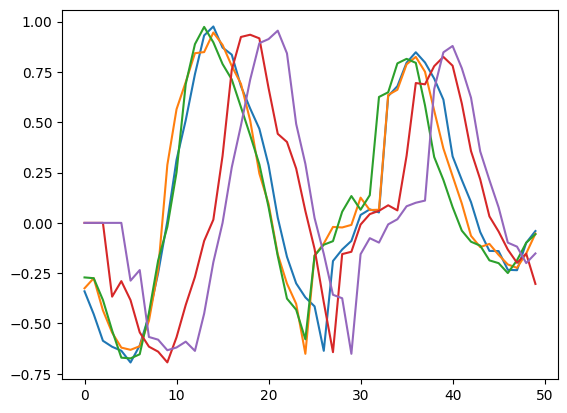

In [23]:
sequence = random_sine()
for _ in range(5):
  plt.plot(permute_signal(sequence))

In [24]:
def generate_data(sample_size=50, batch_size=6):
  X = torch.tensor([random_nums(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))
  
  y = torch.tensor([random_sine(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))

  return X, y


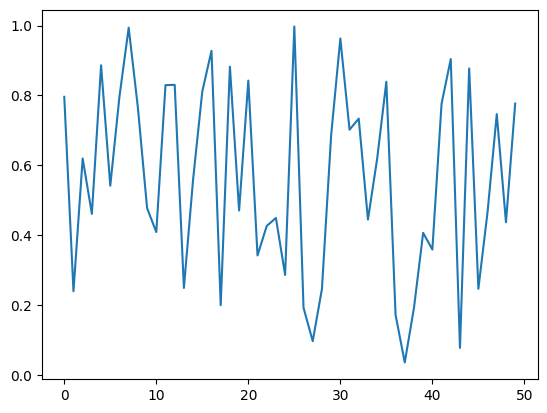

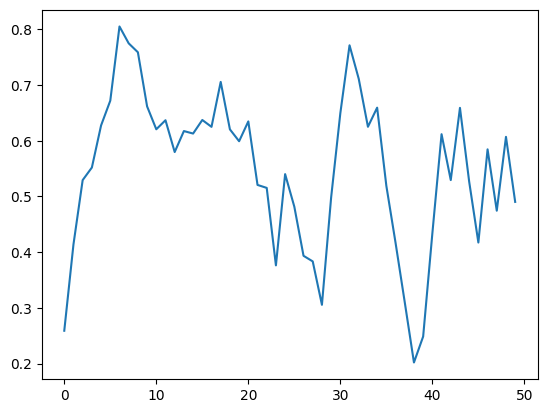

In [26]:
nums = random_nums()
plt.figure()
plt.plot(nums)

plt.figure()
filtered_nums = filter(np.array(nums))
plt.plot(filtered_nums)

# Real data

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
with open('./datasets/guitar-data-long.txt') as f:
  txt = f.readlines()
#model = LSTMMemory(15)
data_pts = []

for pt in txt:
  data_pts.append([float(feature) for feature in pt[:-2].split(' ')])

df = pd.DataFrame(data_pts)
df.columns = ['pitch', 'max', 'specFlat', 'specBright', 'time']

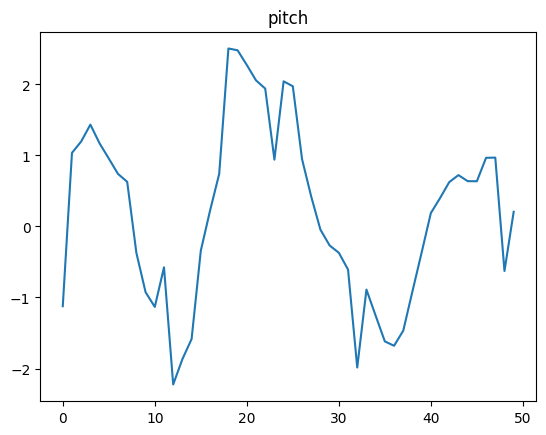

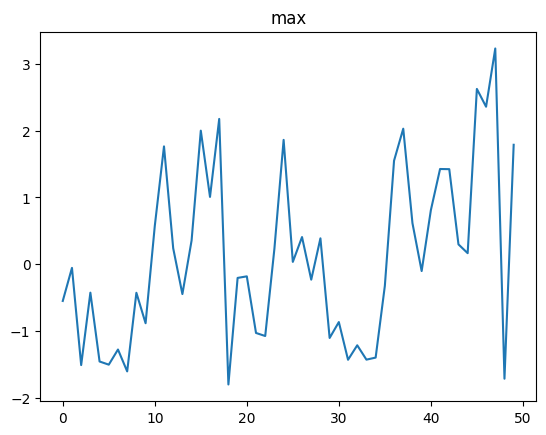

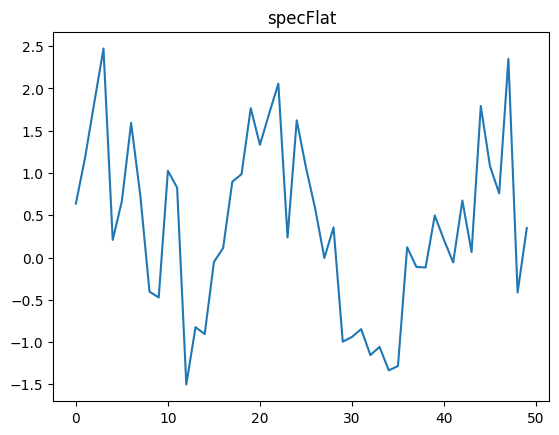

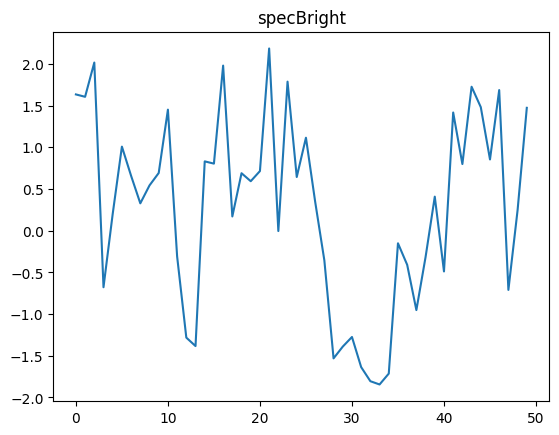

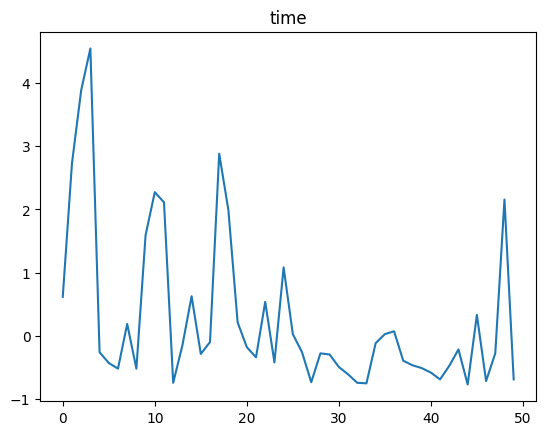

In [30]:
for col in df.columns:
  plt.figure()
  plt.title(col)
  plt.plot(StandardScaler().fit_transform(df[col].to_numpy().reshape(-1, 1))[:50])
  plt.show()

## Filtered Data

In [32]:
filtered_df = df.copy()
kernel = np.ones(10)
for col in filtered_df.columns:
  filtered_df[col] = filter(filtered_df[col].to_numpy(), kernel)

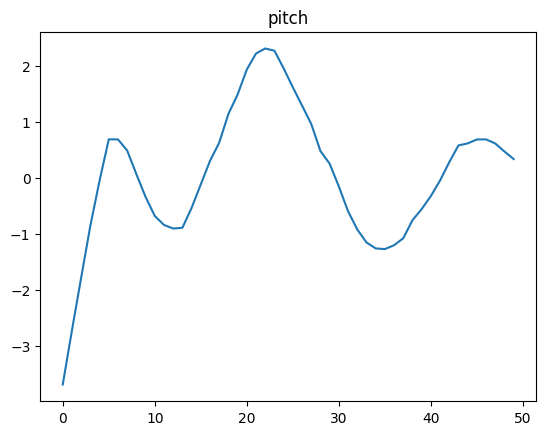

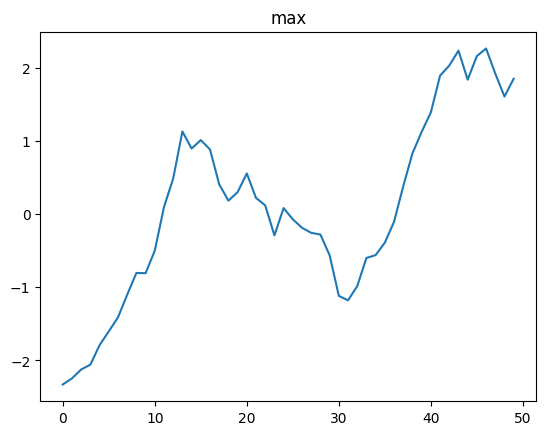

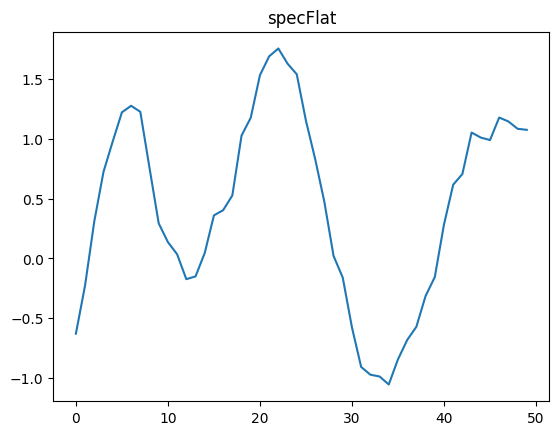

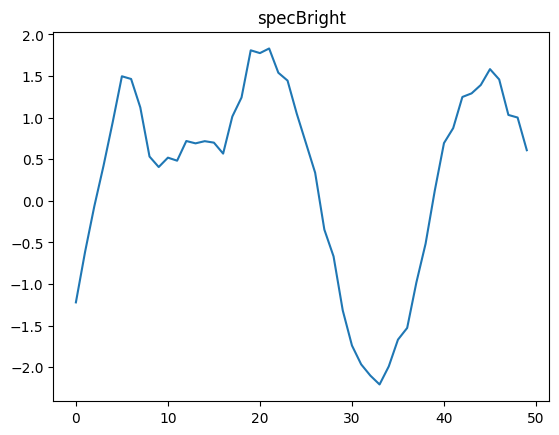

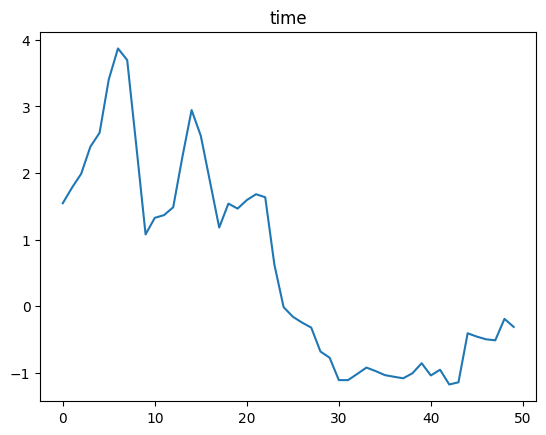

In [33]:
for col in df.columns:
  plt.figure()
  plt.title(col)
  plt.plot(StandardScaler().fit_transform(filtered_df[col].to_numpy().reshape(-1, 1))[:50])
  plt.show()

# MODEL

In [34]:
class LSTMMemory(torch.nn.Module):

  def __init__(self, hidden_size, input_size=1, output_size=1):
    super().__init__()
    self._scaler = StandardScaler()
    self._hidden_state = None
    self.lstm = torch.nn.LSTM(
        input_size = input_size,
        hidden_size = hidden_size,
        batch_first = True
    )
    self.linear = torch.nn.Linear(
            in_features=hidden_size,
            out_features=output_size
        )

  def forward(self, x):
    h = self.lstm(x)[0]

    return self.linear(h)

  def forward_live(self, x):
    
    x = torch.tensor(self._scaler.transform(x).reshape((1, 1)).astype(np.float32))
    if self._hidden_state:
      h, self._hidden_state = self.lstm(x, self._hidden_state)
    else:
      h, self._hidden_state = self.lstm(x)

    return self.linear(h)
  
  def reset_live(self):
    self._hidden_state = None

  def fit(self, data):
    self._scaler.fit(data)

  def transform(self, data):
    return self._scaler.transform(data)

  def fit_transform(self, data):
    return self._scaler.fit_transform(data)


# TESTING

## Random sine -> permuted random sine

In [35]:
def generate_randnums_permutedsines(sample_size=50, batch_size=6):
  X = torch.tensor([random_nums(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))
  
  y = torch.tensor([random_sine(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))

  return X, y

Blue inputs, orange outputs


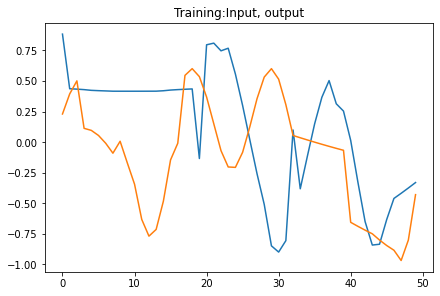

Blue inputs, orange outputs


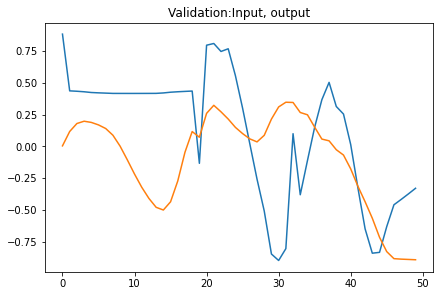

Blue inputs, orange outputs


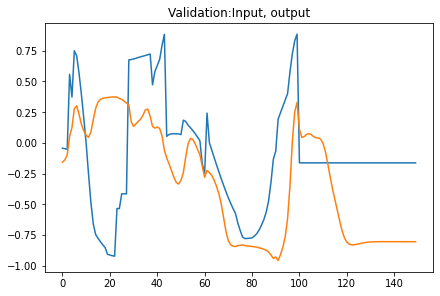

Blue inputs, orange outputs


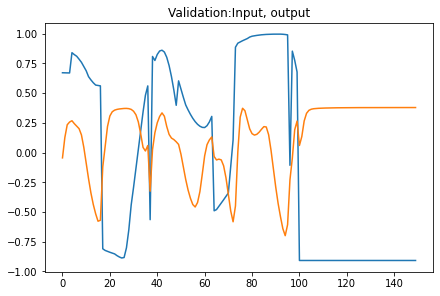

Blue inputs, orange outputs


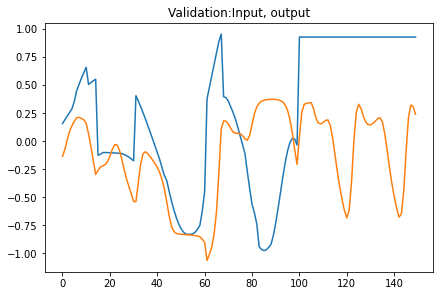

Blue inputs, orange outputs


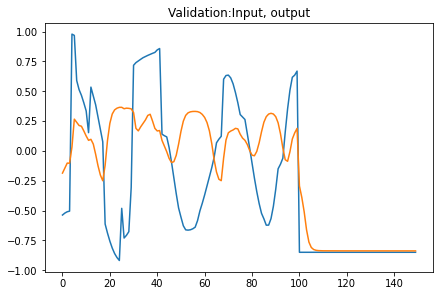

Blue inputs, orange outputs


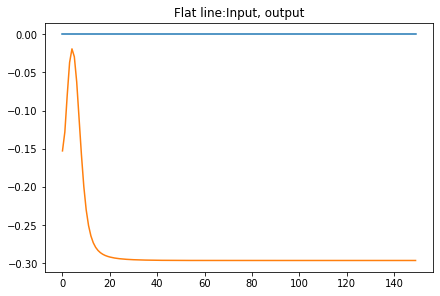

In [ ]:
random.seed(45)
torch.manual_seed(42)

model = LSTMMemory(15)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=.02)
model.train()
x_list = random_sine(50)
X = torch.tensor([x_list for _ in range(6)]).reshape((6, 50, 1))
y_list = [point * 1 for point in random_sine(50)]
curve_plot(1, 1, X, torch.tensor(y_list).reshape(1, 50, 1), "Training:")

for j in range(500):
  optimizer.zero_grad()
  pred = model(X)
  y = torch.tensor([permute_signal(y_list) for _ in range(6)]).reshape((6, 50, 1))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  
  # print(f"Loss = {loss} but why do I care?")
model.eval()
with torch.no_grad():
  val_y = model(X)
curve_plot(1, 1, X, val_y, "Validation:")

for i in range(4):
  with torch.no_grad():
    finisher = random.uniform(-1, 1)
    test_X = torch.tensor((random_sine(100) + [finisher for _ in range(50)])).reshape((1, 150, 1))
    test_predicted_y = model(test_X)
  curve_plot(1, 1, test_X, test_predicted_y, "Validation:")

with torch.no_grad():
  test_X = torch.tensor([0 for _ in range(150)]).reshape((1, 150, 1)).float()
  test_predicted_y = model(test_X)
curve_plot(1, 1, test_X, test_predicted_y, "Flat line:")



# N random sines -> M random permuted sines

Blue inputs, orange outputs


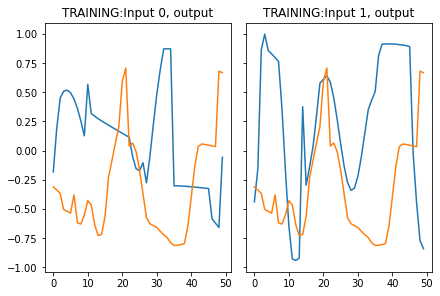

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Blue inputs, orange outputs


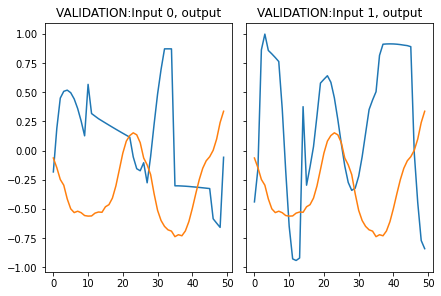

Blue inputs, orange outputs


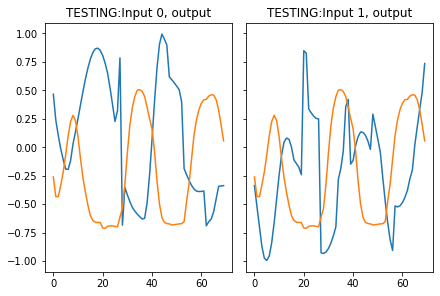

Blue inputs, orange outputs


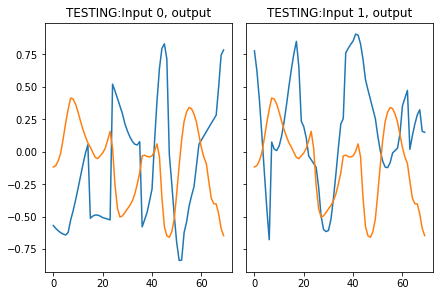

Blue inputs, orange outputs


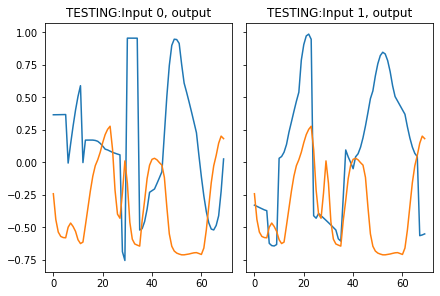

Blue inputs, orange outputs


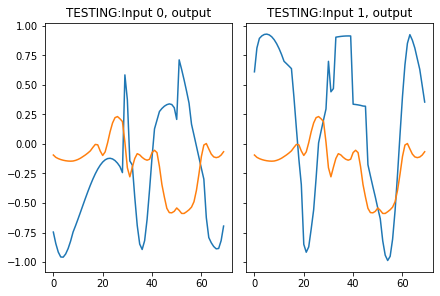

Predicted:  [[[-0.09361688047647476], [-0.11327316612005234], [-0.12409444898366928], [-0.13197526335716248], [-0.13788488507270813], [-0.14207936823368073], [-0.14474593102931976], [-0.14576038718223572], [-0.14439943432807922], [-0.13899806141853333], [-0.13113130629062653], [-0.12043052166700363], [-0.10681124031543732], [-0.09274483472108841], [-0.07654623687267303], [-0.058257050812244415], [-0.029606379568576813], [-0.003834025003015995], [-0.00718433503061533], [-0.05963905155658722], [-0.09727836400270462], [-0.06699956208467484], [0.010605826042592525], [0.10324209183454514], [0.17805761098861694], [0.22305536270141602], [0.23209190368652344], [0.21344034373760223], [0.19031743705272675], [0.015072344802320004], [-0.20125113427639008], [-0.2781587243080139], [-0.19794142246246338], [-0.12307503074407578], [-0.0822424441576004], [-0.09251824766397476], [-0.11359184235334396], [-0.1294044703245163], [-0.13747873902320862], [-0.12930108606815338], [-0.07292847335338593], [-0.0533

In [ ]:
inputs = 2
outputs = 1

random.seed(20)
torch.manual_seed(41)

model_2d_2d = LSTMMemory(15, inputs, outputs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model_2d_2d.parameters(), lr=.02)
model_2d_2d.train()
X_list = list(zip(*[random_sine(50) for _ in range(inputs)]))
X = torch.tensor([X_list for _ in range(6)]).float()
y_list_pure = [random_sine(50) for _ in range(outputs)]
true_y = list(zip(*y_list_pure))
curve_plot(outputs, inputs, X, torch.tensor(true_y).reshape((1, 50, outputs)), "TRAINING:")

for j in range(500):
  optimizer.zero_grad()
  pred = model_2d_2d(X)
  
  y_list = list(zip(*[permute_signal(y) for y in y_list_pure]))
  y = torch.tensor([y_list for _ in range(6)]).reshape((6, 50, outputs))
  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  
  # print(f"Loss = {loss}")
model_2d_2d.eval()


val_pred_y = model_2d_2d(X)
curve_plot(outputs, inputs, X, torch.tensor(val_pred_y).reshape((6, 50, outputs)), "VALIDATION:")



for i in range(4):
  with torch.no_grad():
    test_X_list = list(zip(*[random_sine(70) for _ in range(inputs)]))
    test_X = torch.tensor(test_X_list).reshape((1, 70, inputs))
    test_predicted_y = model_2d_2d(test_X)
  curve_plot(outputs, inputs, test_X, test_predicted_y, "TESTING:")
print("Predicted: ", test_predicted_y.tolist())

# Time since last note + velocity from Bonk

TIMES


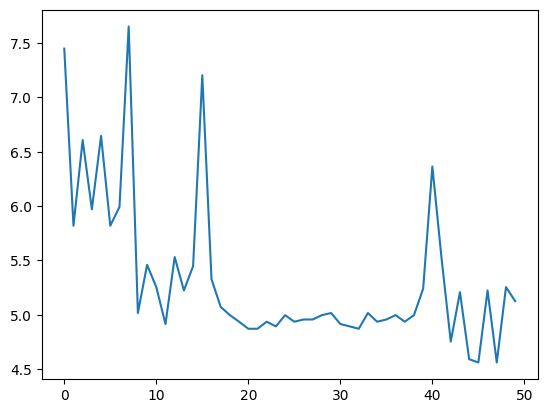

VELS


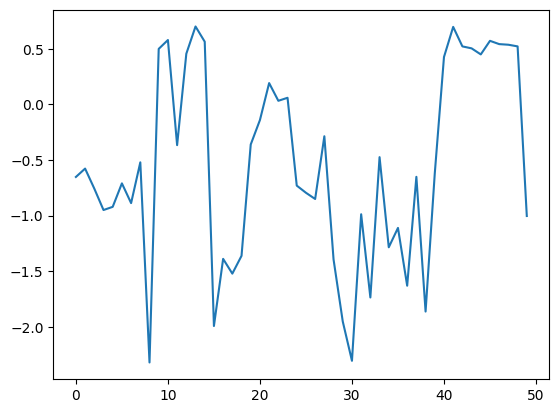

In [ ]:
with open('dataset.txt') as f:
  txt = f.readlines()
model = LSTMMemory(15)
data_pts = []
times = []
vels = []

for pt in txt:
  time, vel = pt.split(' ')
  time = log(float(time))
  vel = float(vel[:-2])
  data_pts.append([time, vel])
  times.append(time)
  vels.append(vel)

times = times[::-1]
scaled_vels = preprocessing.scale(vels[::-1])
scaled_vels2 = model.fit_transform(np.array(vels).reshape(len(vels), 1))
data_pts_np = np.array(data_pts[::-1])

print("TIMES")
plt.figure()
plt.plot(times[:50])
plt.show()
print("VELS")
plt.figure()
plt.plot(scaled_vels[:50])
plt.show()

In [ ]:
X.shape

torch.Size([6, 50, 2])

# Training with multiple real datapoints to one output

favorites - pitch, max.  rand seed 40, torch seed 44

Blue inputs, orange outputs


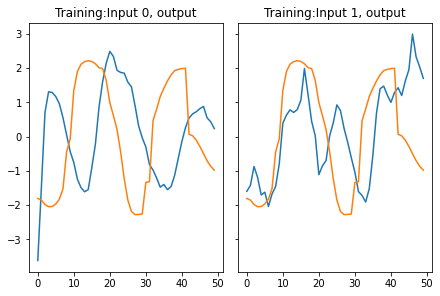

Loss = 0.2998849153518677
Loss = 0.10733169317245483
Loss = 0.10573959350585938
Loss = 0.07914425432682037
Loss = 0.09119866788387299
Loss = 0.1324319988489151
Loss = 0.11736475676298141
Loss = 0.04808926209807396
Loss = 0.06393053382635117
Loss = 0.08313484489917755
Blue inputs, orange outputs


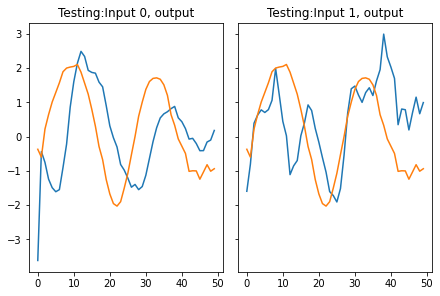

Blue inputs, orange outputs


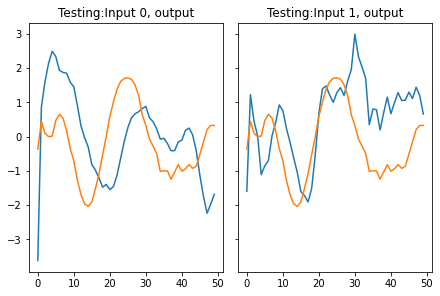

Blue inputs, orange outputs


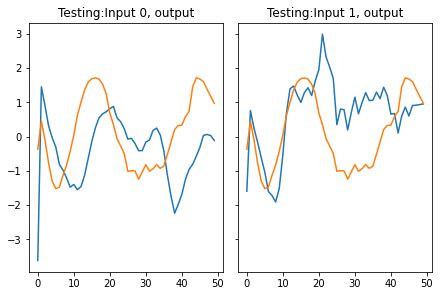

Blue inputs, orange outputs


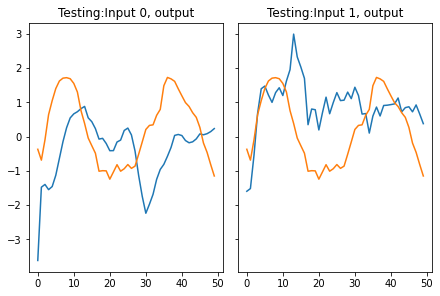

Blue inputs, orange outputs


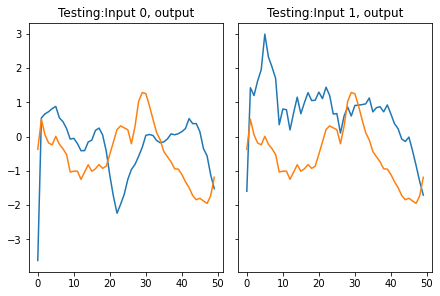

In [ ]:
random.seed(38)
torch.manual_seed(44)

data = filtered_df[['pitch', 'max']].to_numpy(copy=True)

model_2d = LSTMMemory(15, 2, 1)
scaled_data = torch.tensor(model_2d.fit_transform(preprocessing.scale(data)))
X_row = scaled_data[:50]
X = X_row.repeat(6, 1, 1)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model_2d.parameters(), lr=.02)
model_2d.train()

y_list = random_sine(50)
y_tensor = torch.tensor(y_list)
curve_plot(1, 2, X, y_tensor.reshape((1, 50, 1)) * 3, f"Training:")
for j in range(500):
  optimizer.zero_grad()
  pred = model_2d(X.float())
  y = torch.tensor([permute_signal(y_list) for _ in range(6)]).reshape((6, 50, 1))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  if j % 50 == 0:
    print(f"Loss = {loss}")
model_2d.eval()



for i in range(5):
  with torch.no_grad():
    start_index = int((i + 1)* 50 / 6 )
    test_X = scaled_data[start_index:start_index +  50].reshape(1, 50, 2).float()
    test_X[:, 0, :] = X_row[0]
    test_predicted_y = model_2d(test_X)

  curve_plot(1, 2, test_X, test_predicted_y * 3, "Testing:")

In [ ]:
scaled_data.shape

torch.Size([179, 2])

# Multiple real to multiple out

In [36]:
random.seed(1)
torch.manual_seed(42)

outputs = 3

model_2d = LSTMMemory(15, 2, outputs)
scaled_data = torch.tensor(model_2d.fit_transform(data_pts_np))
X_row = scaled_data[:50]
X = X_row.repeat(6, 1, 1)

y_lists = [random_sine(50, max_freq=5 + i * 3, ) for i in range(outputs)]

criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model_2d.parameters(), lr=.02)
model_2d.train()

for j in range(500):
  optimizer.zero_grad()
  pred = model_2d(X.float())

  y_lists_permuted = list(zip(*[permute_signal(y) for y in y_lists]))
  y = torch.tensor([y_lists_permuted for _ in range(6)]).reshape((6, 50, outputs))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  if j % 50 == 49:
    print(f"Loss = {loss}")
model.eval()

y_tensor = torch.tensor(list(zip(*y_lists))).reshape(1, 50, outputs)
curve_plot(outputs, 2, X, y_tensor * 2, prefix="TRAINING:")

curve_plot(outputs, 2, X, model_2d(X.float()) * 2, prefix="VALIDATION:")

for i in range(4):
  with torch.no_grad():
    test_X = scaled_data[(i + 1) * 50:(i + 2) * 50].reshape(1, 50, 2).float()
    test_predicted_y = model_2d(test_X)
  curve_plot(outputs, 2, test_X, test_predicted_y * 2, prefix=f"TESTING ROUND {i}:")

NameError: name 'data_pts_np' is not defined

In [ ]:
t1 = torch.Tensor([1, 2, 3])
t2 = torch.Tensor([4, 5, 6])
torch.stack([t1, t2], dim = -1)

tensor([[1., 4.],
        [2., 5.],
        [3., 6.]])

## Multiple real to multiple models

Loss for model 0 = 0.3127693831920624
Loss for model 1 = 0.6702284812927246
Loss for model 2 = 0.3762420117855072
Loss for model 0 = 0.13326558470726013
Loss for model 1 = 0.04330115392804146
Loss for model 2 = 0.16401603817939758
Loss for model 0 = 0.08941683173179626
Loss for model 1 = 0.05751033127307892
Loss for model 2 = 0.1213945671916008
Loss for model 0 = 0.09248825907707214
Loss for model 1 = 0.054080504924058914
Loss for model 2 = 0.0687103196978569
Loss for model 0 = 0.07857948541641235
Loss for model 1 = 0.04243563115596771
Loss for model 2 = 0.11029356718063354
Loss for model 0 = 0.040192991495132446
Loss for model 1 = 0.0398770235478878
Loss for model 2 = 0.14359067380428314
Loss for model 0 = 0.07027705013751984
Loss for model 1 = 0.04909077286720276
Loss for model 2 = 0.11495575308799744
Loss for model 0 = 0.047449927777051926
Loss for model 1 = 0.051475558429956436
Loss for model 2 = 0.14057594537734985
Loss for model 0 = 0.0816788375377655
Loss for model 1 = 0.0530620

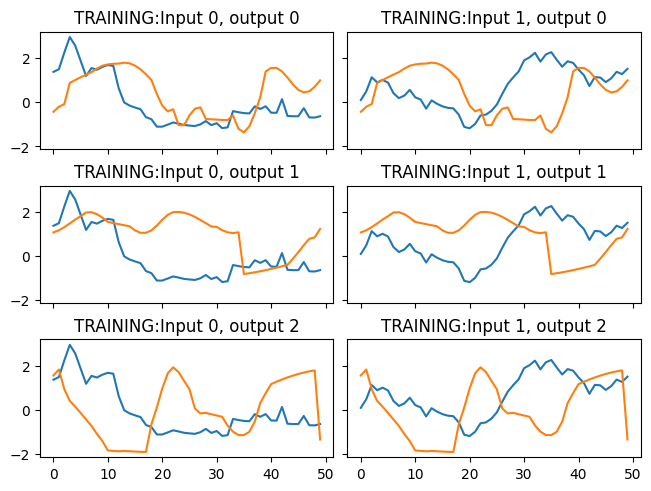

Blue inputs, orange outputs


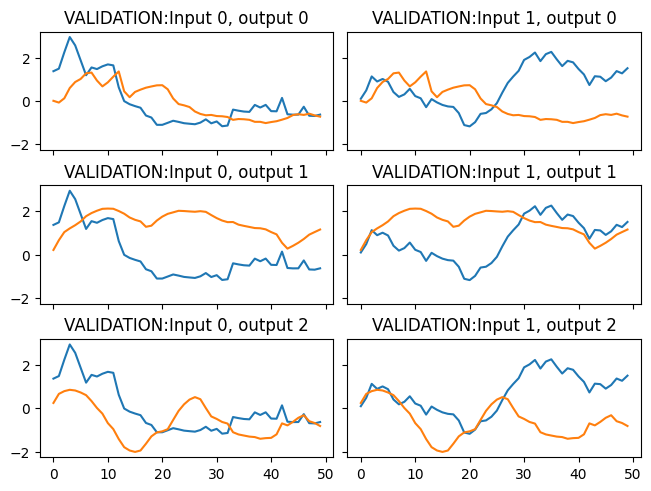

Blue inputs, orange outputs


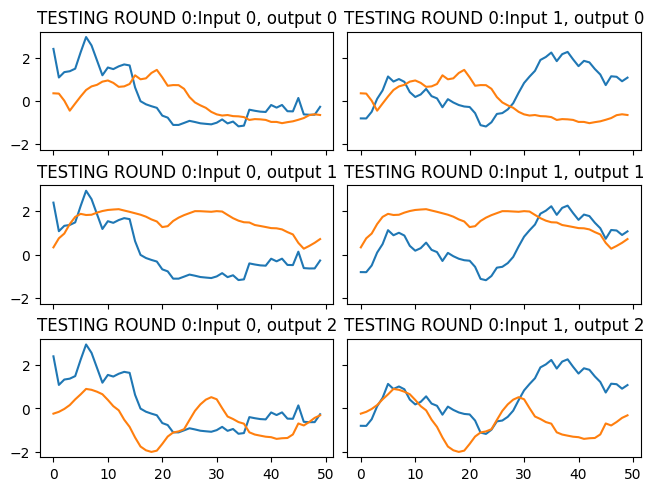

Blue inputs, orange outputs


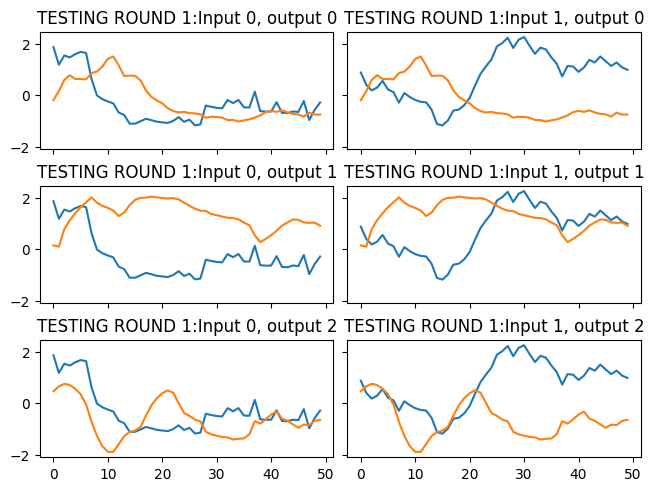

Blue inputs, orange outputs


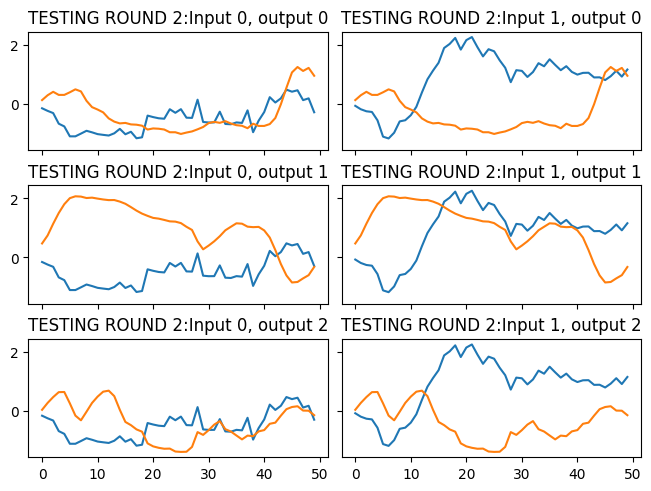

Blue inputs, orange outputs


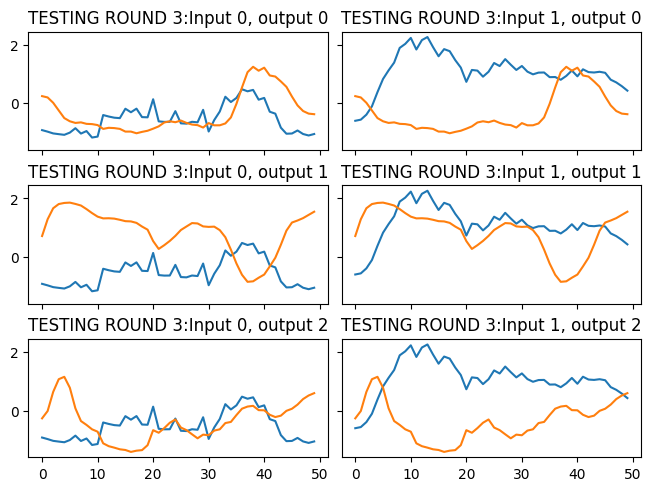

Blue inputs, orange outputs


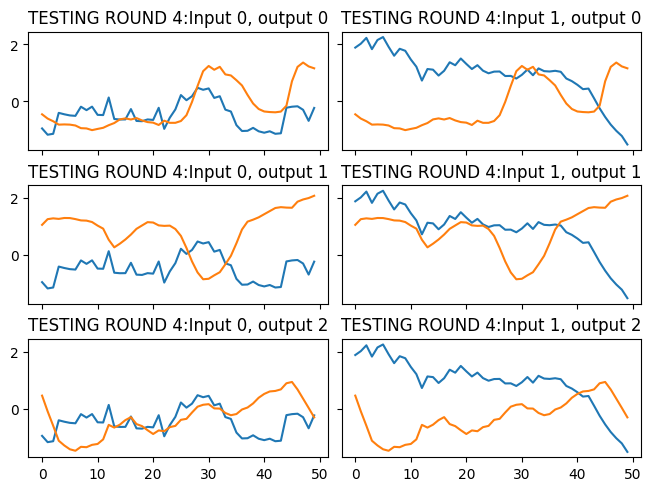

In [48]:
random.seed(93)
torch.manual_seed(48)

outputs = 3

models = [LSTMMemory(25, 2, 1) for _ in range(outputs)]
data_pts_np = filtered_df[['time', 'max']].to_numpy(copy=True)
for model in models:
  model.fit(data_pts_np)
scaled_data = torch.tensor(models[0].transform(data_pts_np))
X_row = scaled_data[11:61]
X = X_row.repeat(6, 1, 1)

y_lists = [random_sine(50) for _ in range(outputs)]

criterion = torch.nn.MSELoss()
optimizers = [torch.optim.RMSprop(model.parameters(), lr=.02) for model in models]
for model in models:
    model.train()

for j in range(500):
  for i in range(outputs):
    optimizers[i].zero_grad()
    pred = models[i](X.float() / 2)

    y = torch.tensor([permute_signal(y_lists[i]) for _ in range(6)]).reshape(6, 50, 1)

    loss = criterion(pred, y)
    loss.backward()
    optimizers[i].step()

    if j % 50 == 0:
      print(f"Loss for model {i} = {loss}")

for model in models:
    model.eval()

y_tensor = torch.tensor(list(zip(*y_lists))).reshape(1, 50, outputs)
curve_plot(outputs, 2, X, y_tensor * 2, prefix="TRAINING:")

valid_list = [model(X.float())[0] for model in models]
validation_out = torch.stack(valid_list, dim=-1).reshape(1, 50, outputs)
curve_plot(outputs, 2, X, validation_out * 2, prefix="VALIDATION:")

for i in range(5):
  with torch.no_grad():
    start_index = int((i + 1)* 50 / 6 )
    test_X = scaled_data[start_index:start_index +  50].reshape(1, 50, 2).float()
    test_predicted_y = torch.stack([model(test_X) for model in models], dim=-1).reshape(1, 50, outputs)
  curve_plot(outputs, 2, test_X, test_predicted_y * 2, prefix=f"TESTING ROUND {i}:")

In [ ]:
torch.stack(valid_list, dim=-1).shape

torch.Size([6, 50, 1, 2])

### Saving

In [49]:
torch.save(models[2], "time-max-1.pt")

# Testing for live usage

In [ ]:
live_outputs = []
test_live_X = torch.tensor(vels[200:250]).reshape((1, 50, 1)).float()

with torch.no_grad():
  model.reset_live()
  for i in range(50):
    live_out = model.forward_live(test_live_X[:, i, :])
    live_outputs.append(live_out.item())

plt.plot(live_outputs)



In [ ]:
live_outputs = []
test_live_X = torch.tensor(vels[200:250]).reshape((1, 50, 1)).float()

with torch.no_grad():
  model.reset_live()
  for i in range(50):
    live_out = model.forward_live(torch.tensor([random.uniform(0, 1)]).reshape(1, 1))
    live_outputs.append(live_out.item())

plt.plot(live_outputs)

In [ ]:
test_live_X[:, 1, :]

In [ ]:
torch.rand((1, 1, 1))